# SpikeInterface tutorial


In this tutorial, we will cover the basics for using SpikeInterface for electrophysiology analysis and spike sorting comparison.

We will analyze a couple of simulated dataset fro MEArec (a tetrode recording and a 32-channel MEA recording) in order to show how to:

- load the data as Extractors
- load a probe file
- preprocess the signals
- run spike sortigng with different parameters
- curate the spike sorting output using Phy


For this tutorial we will need the following packages:
- MEArec
- spikeextractors
- spiketoolkit
- spikewidgets
- klusta
- phy
- matplotlib

+ all their dependencies.

To install those you can use the `requirements.txt` in this folder:

`pip install -r requirements.txt`

First, we need to download a recording. Feel free to use your own recordings as well.

From this [link](https://drive.google.com/file/d/1rstuZTqWAvVIAFCaWceV20n2z8989jiG/view?usp=sharing) you can download a simulated dataset using [MEArec](https://github.com/alejoe91/MEArec).

The recording was generated on a shank probe with 4 tetrodes separated by 300 $\mu$m. It has 36 cells in total, distributed in the proximity of the 4 tetrodes. Let's first load the recordings and check them out.

In [3]:
import spikeextractors as se 
import spiketoolkit as st
import spikewidgets as sw
import matplotlib.pylab as plt
import numpy as np
%matplotlib notebook

### Loading recording and probe information

In [4]:
recording_file = 'recordings_20cells_Neuronexus-32_30.0_10.0uV_16-06-2019:16:27.h5'
recording = se.MEArecRecordingExtractor(recording_file)

Could not load plane information. Assuming probe is in yz plane


The `RecordingExtractor` object contains information about channel ids, locations (if present), sampling frequency, traces.

In [5]:
channel_ids = recording.get_channel_ids()
fs = recording.get_sampling_frequency()
num_chan = recording.get_num_channels()

print('Channel ids', channel_ids)
print('Sampling frequency', fs)
print('Number of channels', num_chan)

Channel ids [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Sampling frequency 32000.0
Number of channels 32


Let's plot the channel locations and a snippet of traces:

<IPython.core.display.Javascript object>


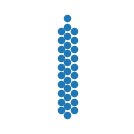

In [8]:
sw.plot_electrode_geometry(recording)

In [5]:
trace_snippet = recording.get_traces(start_frame=int(fs*0), end_frame=int(fs*2))

In [6]:
plt.figure()
alpha = 0.7
plt.plot(trace_snippet[:4].T, 'r', alpha=alpha)
plt.plot(trace_snippet[4:8].T, 'b', alpha=alpha)
plt.plot(trace_snippet[8:12].T, 'g', alpha=alpha)
plt.plot(trace_snippet[12:].T, 'y', alpha=alpha)

<IPython.core.display.Javascript object>

NameError: name 'trace_snippet' is not defined

In [7]:
sw.plot_timeseries(recording)

We can see that the spikes mainly appear separately on different tetrode. We can load the `group` information in two ways:

- using the `set_channel_groups` function from `spikeextractors`
- loading a probe file using the `load_probe_file` function

Let's try the second option.

Probe files are (`.prb`) also enable users to change the channel map (reorder the channels), add channel grouping properties and locations. In this case our probe file will order the channels in revers and split them in 4 groups, representing the 4 tetrodes.

In [7]:
!cat tetrode_16.prb

In [8]:
recording_prb = se.load_probe_file(recording, 'tetrode_16.prb')

In [9]:
print('Original channels:', recording.get_channel_ids())
print('Channels and groups after loading the probe file:', recording_prb.get_channel_ids(), recording_prb.get_channel_groups())

Original channels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Channels and groups after loading the probe file: [12, 13, 14, 15, 8, 9, 10, 11, 4, 5, 6, 7, 0, 1, 2, 3] [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]


### Preprocessing recordings


Now that the probe information is loaded we can do some preprocessing usng `spiketoolkit`.

We can filter the recordings, change the reference to remove noise, discard noisy channels, whiten the data, remove stimulation artifacts, etc. (more info [here](https://spiketoolkit.readthedocs.io/en/latest/preprocessing_example.html)).

Let's for example filter the recordings, remove a noisy channel, and apply common median reference (CMR). The output of preprocessing modules are also `RecordingExtractor` objects, so we can use the same basic functions for extracting traces, get channel ids and so on.

In [10]:
recording_f = st.preprocessing.bandpass_filter(recording_prb, freq_min=300, freq_max=6000)
recording_rm_noise = st.preprocessing.remove_bad_channels(recording_f, bad_channels=[5])
recording_cmr = st.preprocessing.common_reference(recording_rm_noise, reference='median')

In [11]:
trace_f_snippet = recording_f.get_traces(start_frame=int(fs*0), end_frame=int(fs*2))
trace_cmr_snippet = recording_cmr.get_traces(start_frame=int(fs*0), end_frame=int(fs*2))

Preprocessing modules can be pipelined. In this example, we applied CMR after removing one channel

In [12]:
print(trace_f_snippet.shape)
print(trace_cmr_snippet.shape)

(16, 64000)
(15, 64000)


In [13]:
print('Channel ids and groups for CMR recordings', recording_cmr.get_channel_ids(), recording_cmr.get_channel_groups())

Channel ids and groups for CMR recordings [12, 13, 14, 15, 8, 9, 10, 11, 4, 6, 7, 0, 1, 2, 3] [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3]


### Spike sorting

We can now run spike sorting. We will use `klusta` for this demonstration and we will run spike sorting of split by group.

Let's first check the available (installed) sorters and `klusta` default parameters.

We will use the `recording_f` object, as there is no external noise and all channels are good :)

In [14]:
st.sorters.installed_sorter_list

[spiketoolkit.sorters.klusta.klusta.KlustaSorter,
 spiketoolkit.sorters.tridesclous.tridesclous.TridesclousSorter,
 spiketoolkit.sorters.mountainsort4.mountainsort4.Mountainsort4Sorter,
 spiketoolkit.sorters.ironclust.ironclust.IronclustSorter,
 spiketoolkit.sorters.kilosort.kilosort.KilosortSorter,
 spiketoolkit.sorters.kilosort2.kilosort2.Kilosort2Sorter,
 spiketoolkit.sorters.spyking_circus.spyking_circus.SpykingcircusSorter,
 spiketoolkit.sorters.herdingspikes.herdingspikes.HerdingspikesSorter]

In [15]:
st.sorters.KlustaSorter.default_params()

{'probe_file': None,
 'adjacency_radius': None,
 'threshold_strong_std_factor': 5,
 'threshold_weak_std_factor': 2,
 'detect_sign': -1,
 'extract_s_before': 16,
 'extract_s_after': 32,
 'n_features_per_channel': 3,
 'pca_n_waveforms_max': 10000,
 'num_starting_clusters': 50}

We will set the `adjacency_radius` to 50, electrodes belonging to the same tetrode are within this distance.

In [16]:
# run spike sorting on entire recording
sorting_KL_all = st.sorters.run_klusta(recording_f, adjacency_radius=50)
print('Found', len(sorting_KL_all.get_unit_ids()), 'units')

Klusta units are not unique! Using unique unit ids
Found 36 units


In [17]:
# run spike sorting by group
sorting_KL_split = st.sorters.run_klusta(recording_f, adjacency_radius=50, grouping_property='group')
print('Found', len(sorting_KL_split.get_unit_ids()), 'units')

Found 38 units


The spike sorting returns a `SortingExtractor` object. Let's see some of its functions:

In [18]:
print('Units', sorting_KL_split.get_unit_ids())

Units [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]


In [19]:
print('Units', sorting_KL_split.get_unit_spike_train(0))

Units [  9388   9415  12657  17754  32922  42588  42959  80434  82683  87534
  91716 135162 141752 145556 148592 170460 233373 258508 258861 266805
 268069 289723 312511 315226 315245 322591 331630 341587 344621 344635
 381891 391245 420865 424676 424696 475952 476236 487887 505684 522658
 527161 546196 549739 562475 570501 571510 571526 575456 582294 585392
 599264 600956 619220 635583 636944 641120 662834 688926 702830 707816
 708956 717229 730333 738660 738876 738897 751451 762979 762999 763747
 768930 768941 776486 782003 812969 812986 823890 823903 828407 830153
 830538 855013 865821 873095 886716 890062 899426 927666 930097 930112
 941563 956333]


In [20]:
st.postprocessing.export_to_phy(recording_f, sorting_KL_all, output_folder='phy_KL_all', grouping_property='group')
st.postprocessing.export_to_phy(recording_f, sorting_KL_split, output_folder='phy_KL_split', grouping_property='group')

In [21]:
%%capture --no-display
!phy template-gui  /home/alessiob/Documents/Codes/spike_sorting/spikeinterface/spiketutorials/Spike_soring_workshop_2019/phy_KL_split/params.py

In [22]:
%%capture --no-display
!phy template-gui  /home/alessiob/Documents/Codes/spike_sorting/spikeinterface/spiketutorials/Spike_soring_workshop_2019/phy_all/params.py

After curating the results we can reload it using the `PhySortingExtractor`:

In [23]:
sorting_KL_all_curated = se.PhySortingExtractor('phy_all/')
sorting_KL_split_curated = se.PhySortingExtractor('phy_split/')

### Some more sorting!!!

If you have other sorters installed, you can try to run them:

In [24]:
%%capture --no-display
sorting_SC = st.sorters.run_spykingcircus(recording_f, adjacency_radius=50, grouping_property='group')

In [25]:
st.postprocessing.export_to_phy(recording_f, sorting_SC, output_folder='phy_SC', grouping_property='group')

In [26]:
%%capture --no-display
!phy template-gui  /home/alessiob/Documents/Codes/spike_sorting/spikeinterface/spiketutorials/Spike_soring_workshop_2019/phy_SC/params.py

In [27]:
sorting_SC_curated = se.PhySortingExtractor('phy_SC')

### Comparison with ground-truth

MEArec recordings are simulated, therefore we know ground truth information about the spiking times. 
We can load the ground truth `SortingExtractor` as:

In [28]:
sorting_gt = se.MEArecSortingExtractor(recording_file)

Now we can compare the sorting output to the ground truth information:

In [29]:
cmp_KL = st.comparison.compare_sorter_to_ground_truth(sorting_gt, sorting_KL_split)

In [30]:
cmp_KL.get_performance()

,accuracy,recall,precision,false_discovery_rate,miss_rate,misclassification_rate
gt_unit_id,,,,,,
0,0.000000,0.000000,NaN,NaN,1.000000,0.000000
1,0.000000,0.000000,NaN,NaN,1.000000,0.000000
2,0.000000,0.000000,NaN,NaN,1.000000,0.000000
3,0.952756,0.952756,1.000000,0.000000,0.047244,0.000000
4,0.000000,0.000000,NaN,NaN,1.000000,0.000000
5,0.893491,0.898810,0.993421,0.006579,0.101190,0.000000
6,0.000000,0.000000,NaN,NaN,1.000000,0.000000
7,0.000000,0.000000,NaN,NaN,1.000000,0.000000
8,0.000000,0.000000,NaN,NaN,1.000000,0.000000


In [31]:
cmp_SC = st.comparison.compare_sorter_to_ground_truth(sorting_gt, sorting_SC)

In [32]:
cmp_SC.get_performance()

,accuracy,recall,precision,false_discovery_rate,miss_rate,misclassification_rate
gt_unit_id,,,,,,
0,0.979452,0.986207,0.993056,0.006944,0.013699,0.006849
1,0.958333,0.958333,1.000000,0.000000,0.031250,0.250000
2,0.978723,0.978723,1.000000,0.000000,0.020833,0.020833
3,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
4,0.715278,0.735714,0.962617,0.037383,0.238710,0.096774
5,0.976048,0.976048,1.000000,0.000000,0.023810,0.005952
6,0.857143,0.880000,0.970588,0.029412,0.113924,0.050633
7,0.000000,0.000000,NaN,NaN,1.000000,0.000000
8,0.000000,0.000000,NaN,NaN,1.000000,0.000000


## Exercise) Can you improve the performance with manual curation?

### Multi sorting comparison

Finally, we can compare KL and SC (or more) and automatically curate the sorting output by retaining the matching units between the two (or more) sorters. We will use the `compare_multiple_sorters` function.
The multi sorting comparison builds a graph with all the units from the different sorters, connected with their agreement score. We can use this to extract agreement sorting.

In [33]:
msc = st.comparison.compare_multiple_sorters(sorting_list=[sorting_KL_split, sorting_SC], name_list=['KL', 'SC'])

In [34]:
sorting_agreement = msc.get_agreement_sorting(minimum_matching=2)

In [35]:
print('Klusta units', len(sorting_KL_split.get_unit_ids()))
print('Spyking-circus units', len(sorting_SC.get_unit_ids()))
print('Agreement units', len(sorting_agreement.get_unit_ids()))

Klusta units 38
Spyking-circus units 38
Agreement units 23


We can still inspect the agreement sorting using Phy:

In [36]:
st.postprocessing.export_to_phy(recording_f, sorting_agreement, output_folder='phy_AGR', grouping_property='group')

In [37]:
%%capture --no-display
!phy template-gui  /home/alessiob/Documents/Codes/spike_sorting/spikeinterface/spiketutorials/Spike_soring_workshop_2019/phy_AGR/params.py